# Travel Insurance Prediction

## Preprocessing

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import warnings
from typing import Dict, Tuple
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, auc, \
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from skopt import BayesSearchCV

warnings.filterwarnings('ignore')
pd.set_option('display.colheader_justify', 'center')

In [58]:
# Load the data
def load_data(path: str) -> pd.DataFrame:
    return pd.read_csv(path, engine='pyarrow', dtype_backend='pyarrow')


PATH = 'data/TravelInsurancePrediction.csv'
data = load_data(PATH)

In [59]:
# Format the values
def format_data(df: pd.DataFrame) -> pd.DataFrame:
    df['ChronicDiseases'] = df['ChronicDiseases'].map({
        1: 'Yes',
        0: 'No'
    }).astype('category')

    return df

In [60]:
# Change the data type
def change_data_type(df: pd.DataFrame) -> pd.DataFrame:
    return df.astype({
        'Age': 'uint8[pyarrow]',
        'Employment Type': 'category',
        'GraduateOrNot': 'category',
        'AnnualIncome': 'uint32[pyarrow]',
        'FamilyMembers': 'uint8[pyarrow]',
        'ChronicDiseases': 'category',
        'FrequentFlyer': 'category',
        'EverTravelledAbroad': 'category',
        'TravelInsurance': 'category'
    })

In [61]:
# Preprocess the data
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(df.columns[0], axis=1)
    df = format_data(df)
    df = change_data_type(df)
    df = df.drop_duplicates()
    return df.reset_index(drop=True)


data = preprocess_data(data.copy())

## Data and Methods

In [62]:
data.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,Yes,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,No,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,Yes,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,Yes,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,Yes,Yes,No,0


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Age                  1249 non-null   uint8[pyarrow] 
 1   Employment Type      1249 non-null   category       
 2   GraduateOrNot        1249 non-null   category       
 3   AnnualIncome         1249 non-null   uint32[pyarrow]
 4   FamilyMembers        1249 non-null   uint8[pyarrow] 
 5   ChronicDiseases      1249 non-null   category       
 6   FrequentFlyer        1249 non-null   category       
 7   EverTravelledAbroad  1249 non-null   category       
 8   TravelInsurance      1249 non-null   category       
dtypes: category(6), uint32[pyarrow](1), uint8[pyarrow](2)
memory usage: 16.0 KB


## Exploratory Data Analysis

In [64]:
eda = data.copy()
eda['TravelInsurance'] = eda['TravelInsurance'].map({
    1: 'Yes',
    0: 'No'
}).astype('category')
num = eda.select_dtypes(include='number')
cat = eda.select_dtypes(include='category')

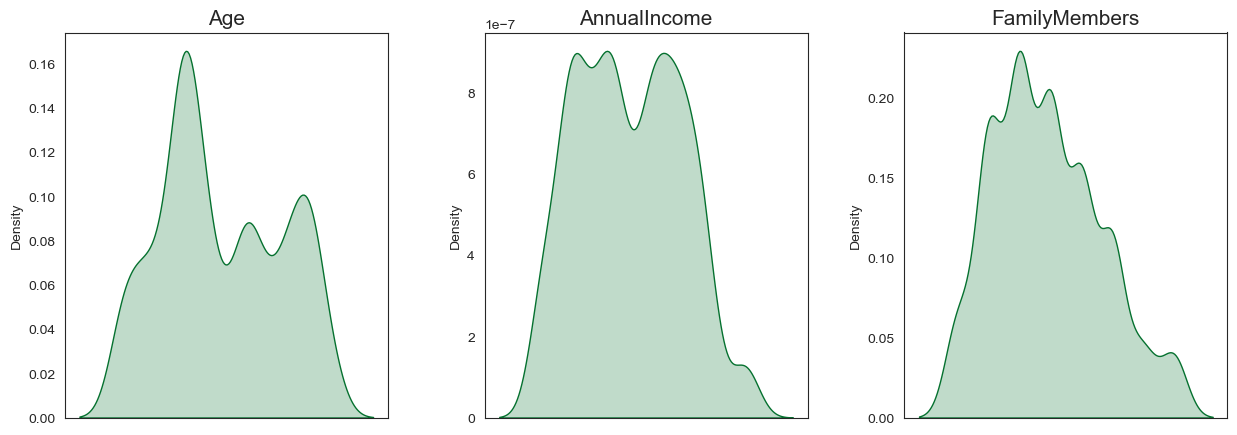

In [65]:
# Plot the distribution of the numerical features
def plot_distribution(df: pd.DataFrame) -> None:
    sns.set_palette('BuGn_r')
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for ax, col in zip(axes.flatten(), df.columns):
        sns.kdeplot(df[col], ax=ax, fill=True)
        ax.set_title(col, fontsize=15)
        ax.set_xlabel('')
        ax.set_xticks([])

    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()


plot_distribution(num)

In [66]:
# Table of basic statistics of the numerical features
def basic_statistics(df: pd.DataFrame) -> pd.io.formats.style.Styler:
    return df.describe().style \
        .format('{:.2f}') \
        .background_gradient(cmap='Paired') \
        .set_properties(**{
        'font-size': '10pt',
        'width': '100px',
        'height': '30px',
        'text-align': 'center'}) \
        .set_caption('Table 1. Basic statistics of the numerical features')


basic_statistics(num)

,Age,AnnualIncome,FamilyMembers
count,1249.00,1249.00,1249.00
mean,29.76,934547.64,4.89
std,2.92,360729.28,1.76
min,25.00,300000.00,2.00
25%,28.00,600000.00,4.00
50%,29.00,900000.00,5.00
75%,32.00,1200000.00,6.00
max,35.00,1800000.00,9.00


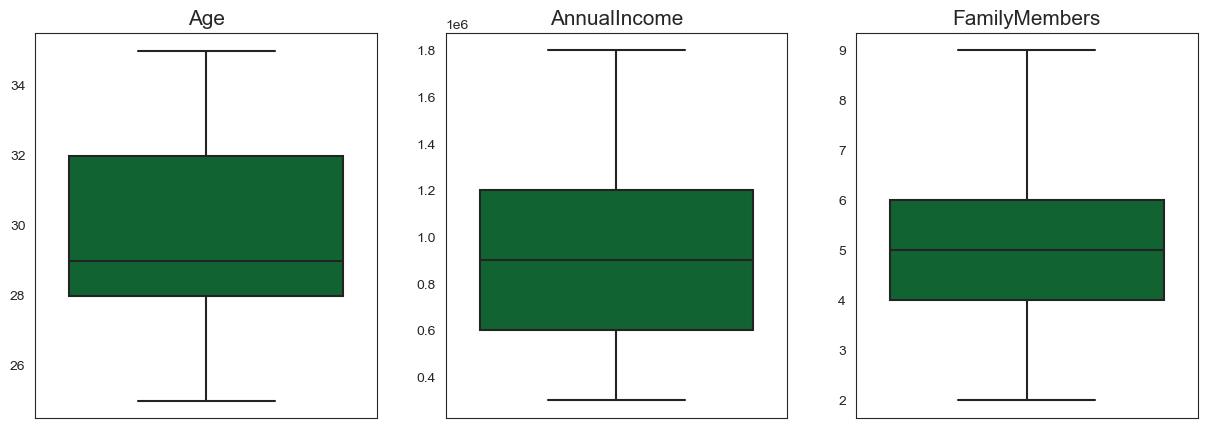

In [67]:
# Plot the statistics of the numerical features
def plot_statistics(df: pd.DataFrame) -> None:
    sns.set_palette('BuGn_r')
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for ax, col in zip(axes.flatten(), df.columns):
        sns.boxplot(df[col], ax=ax)
        ax.set_title(col, fontsize=15)
        ax.set_xlabel('')
        ax.set_xticks([])

    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()


plot_statistics(num)

In [68]:
# Table of the number of outliers
def number_of_outliers(df: pd.DataFrame) -> pd.io.formats.style.Styler:
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    return ((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))).sum() \
        .to_frame('number_of_outliers').style.background_gradient(cmap='Paired') \
        .set_properties(**{
        'font-size': '10pt',
        'width': '100px',
        'height': '30px',
        'text-align': 'center'}) \
        .set_caption('Table 2. Number of outliers')


number_of_outliers(num)

,number_of_outliers
Age,0
AnnualIncome,0
FamilyMembers,0


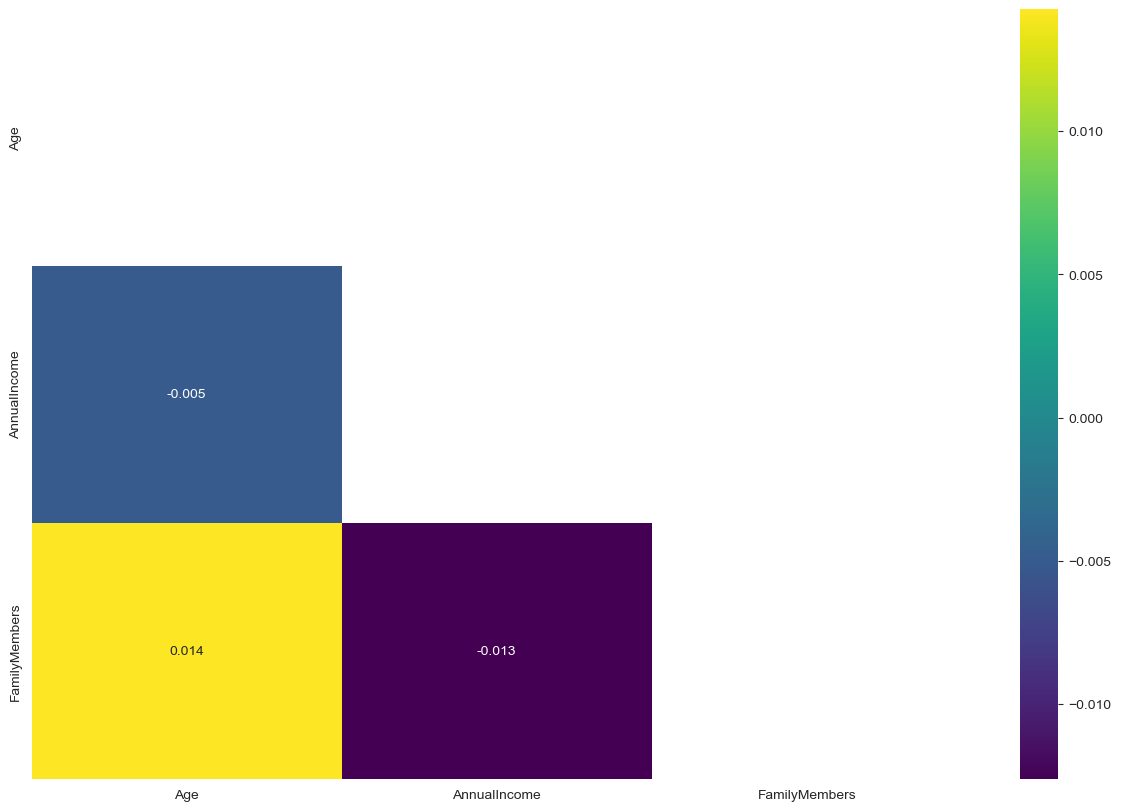

In [69]:
# Plot the correlation between the features
def plot_correlation(df: pd.DataFrame) -> None:
    corr = df.corr()

    fig, ax = plt.subplots(figsize=(15, 10))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(df.corr(), annot=True, ax=ax, cmap='viridis', mask=mask)

    plt.show()


plot_correlation(num)

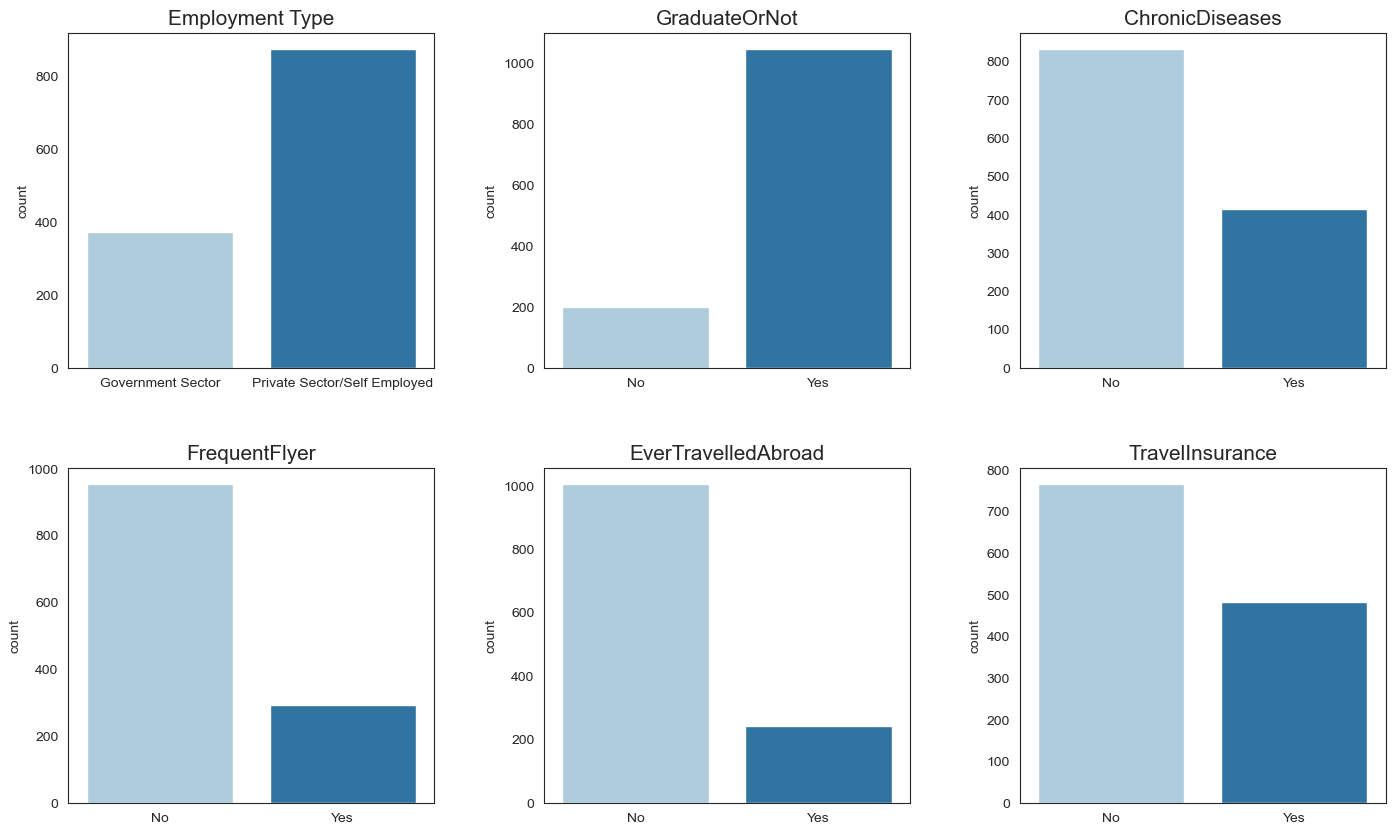

In [70]:
# Plot the distribution of the categorical features
def plot_distribution_cat(df: pd.DataFrame) -> None:
    sns.set_palette('Paired')
    fig, axes = plt.subplots(2, 3, figsize=(17, 10))

    for ax, col in zip(axes.flatten(), df.columns):
        sns.countplot(data=df, x=col, ax=ax)
        ax.set_title(col, fontsize=15)
        ax.set_xlabel('')

    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()


plot_distribution_cat(cat)

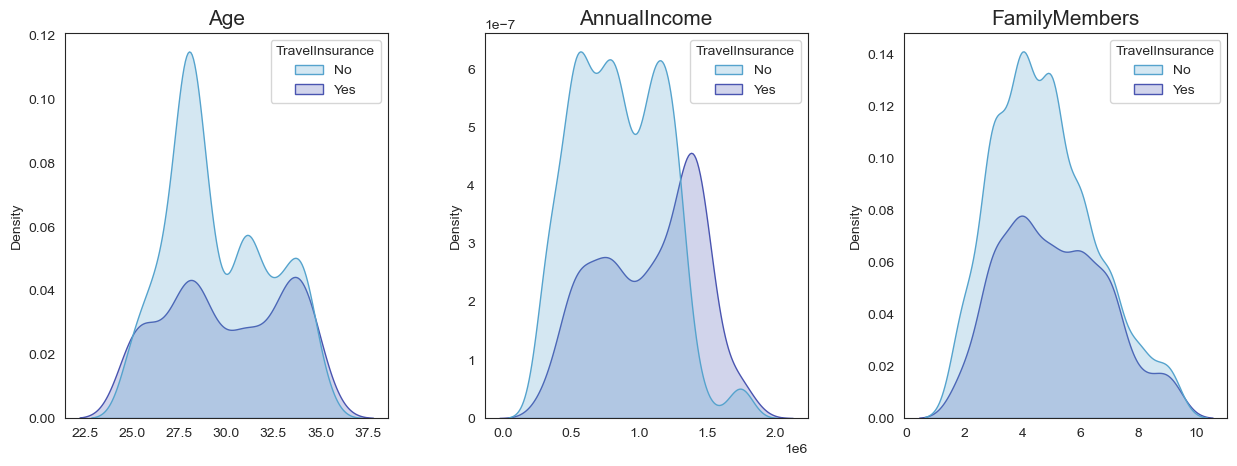

In [71]:
# Plot the distribution of the numerical features by the target
def plot_distribution_target(df: pd.DataFrame) -> None:
    sns.set_palette('icefire')
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for ax, col in zip(axes.flatten(), df.columns.delete(-1)):
        sns.kdeplot(data=df, x=col, hue='TravelInsurance', ax=ax, fill=True)
        ax.set_title(col, fontsize=15)
        ax.set_xlabel('')

    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()


plot_distribution_target(pd.concat([num, cat.TravelInsurance], axis=1))

### Explore the effect of the chronic diseases on travel insurance

Figure 1. The effect of the chronic diseases on travel insurance


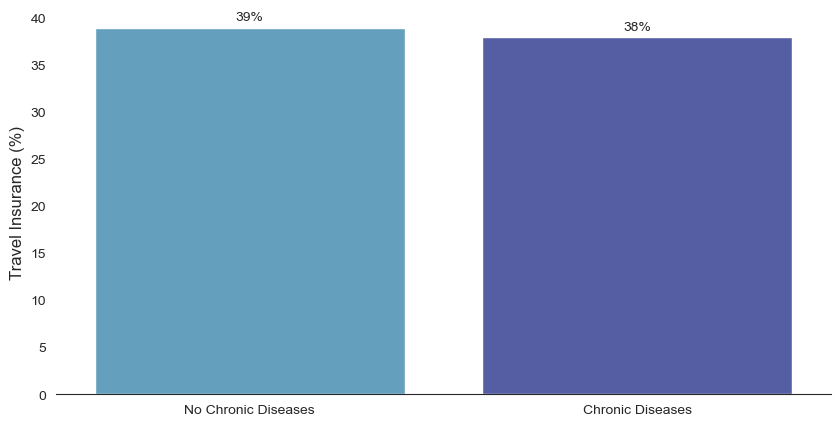

In [72]:
# Plot the effect of the chronic diseases on travel insurance
def plot_chronic_diseases_by_target(df: pd.DataFrame) -> None:
    df.ChronicDiseases = df.ChronicDiseases.map({
        'Yes': 'Chronic Diseases',
        'No': 'No Chronic Diseases'
    })

    insurance_rate = df.groupby('ChronicDiseases')['TravelInsurance'] \
        .value_counts(normalize=True) \
        .mul(100).round() \
        .reset_index(name='Travel Insurance (%)') \
        .query('TravelInsurance == "Yes"')

    sns.set_palette('icefire')
    fig, ax = plt.subplots(figsize=(10, 5))

    sns.barplot(data=insurance_rate,
                x='ChronicDiseases',
                y='Travel Insurance (%)')

    for bar in ax.patches:
        height = bar.get_height()
        x_ = bar.get_x() + bar.get_width() / 2
        y_ = height
        label = f"{height:.0f}%"
        ax.annotate(label, (x_, y_),
                    ha='center', va='bottom',
                    xytext=(0, 3), fontsize=10,
                    textcoords='offset points')

    sns.despine(left=True)
    plt.ylabel('Travel Insurance (%)', fontsize=12)
    plt.xlabel('')

    plt.show()


print('Figure 1. The effect of the chronic diseases on travel insurance')
plot_chronic_diseases_by_target(eda.copy())

From the bar plot above we can conclude that:
- **38% of patients with chronic diseases have travel insurance.**
- **39% of patients without chronic diseases have travel insurance.**

It appears that patients without chronic diseases have a higher travel insurance rate than those with chronic diseases.
- But are these data reliable?
- Are they significant, or are they the product of randomness?

We decide to perform a chi-square test of independence to verify the reliability of the data
- **Null hypothesis**: There is no association between chronic diseases and travel insurance rate.
- **Alternative hypothesis**: Chronic diseases and travel insurance rate are associated.
- **Threshold**: p-value < 0.05

In [73]:
# Chi-square test of independence
def chi_square_test(df: pd.DataFrame, cols: Tuple[str, str]) -> Tuple[float, float, int, np.ndarray]:
    table = pd.crosstab(df[cols[0]], df[cols[1]])
    return chi2_contingency(table.values)

In [74]:
# Chi-square test for chronic diseases and travel insurance
def chronic_diseases_travel_insurance_test(df: pd.DataFrame) -> None:
    chi2, p, df, expected = chi_square_test(df, ('ChronicDiseases', 'TravelInsurance'))
    print(f'Chi-square test of independence: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of freedom: {df}')
    print(f'Expected frequencies: {expected}')
    print(f'p-value < 0.05: {p < 0.05}')
    print(f'Chi-square test of independence > 3.84: {chi2 > 3.84}')


print('Chi-square test for chronic diseases and travel insurance')
chronic_diseases_travel_insurance_test(eda.copy())

Chi-square test for chronic diseases and travel insurance
Chi-square test of independence: 0.0854420539603025
p-value: 0.7700536442454782
Degrees of freedom: 1
Expected frequencies: [[510.87109688 322.12890312]
 [255.12890312 160.87109688]]
p-value < 0.05: False
Chi-square test of independence > 3.84: False


The chi-square test of independence shows that:
- **p-value > 0.05**
- **Chi-square test of independence < 3.84**

Therefore, we don't have enough evidence to reject the null hypothesis.

### Explore the effect of ever travel abroad on travel insurance

Figure 2. The effect of ever travel abroad on travel insurance


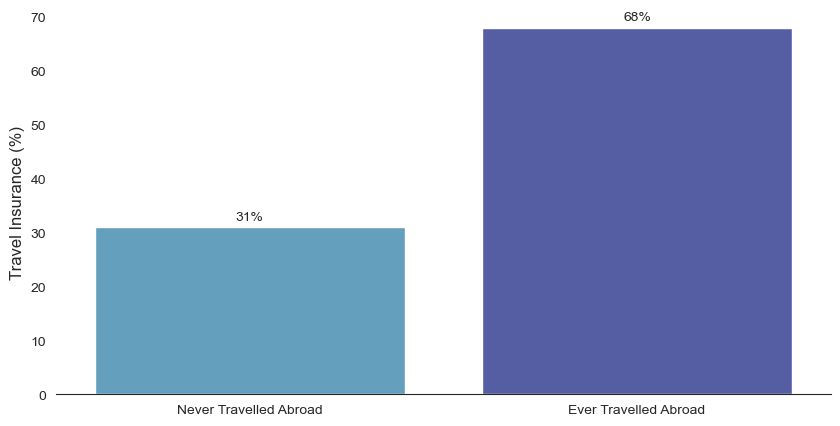

In [75]:
# Plot the effect of ever travel abroad on travel insurance
def plot_ever_travel_abroad_by_target(df: pd.DataFrame) -> None:
    df.EverTravelledAbroad = df.EverTravelledAbroad.map({
        'Yes': 'Ever Travelled Abroad',
        'No': 'Never Travelled Abroad'
    })

    insurance_rate = df.groupby('EverTravelledAbroad')['TravelInsurance'] \
        .value_counts(normalize=True) \
        .mul(100).round() \
        .reset_index(name='Travel Insurance (%)') \
        .query('TravelInsurance == "Yes"')

    sns.set_palette('icefire')
    fig, ax = plt.subplots(figsize=(10, 5))

    sns.barplot(data=insurance_rate,
                x='EverTravelledAbroad',
                y='Travel Insurance (%)')

    for bar in ax.patches:
        height = bar.get_height()
        x_ = bar.get_x() + bar.get_width() / 2
        y_ = height
        label = f"{height:.0f}%"
        ax.annotate(label, (x_, y_),
                    ha='center', va='bottom',
                    xytext=(0, 3), fontsize=10,
                    textcoords='offset points')

    sns.despine(left=True)
    plt.ylabel('Travel Insurance (%)', fontsize=12)
    plt.xlabel('')

    plt.show()


print('Figure 2. The effect of ever travel abroad on travel insurance')
plot_ever_travel_abroad_by_target(eda.copy())

From the bar plot above we can conclude that:
- **68% of people who have ever travel abroad have travel insurance.**
- **31% of people who have never travel abroad have travel insurance.**

It appears that people who have ever travel abroad have a higher travel insurance rate than those who have never travel abroad.
- But are these data reliable?
- Are they significant, or are they the product of randomness?

We decide to perform a chi-square test of independence to verify the reliability of the data
- **Null hypothesis**: There is no association between ever travel abroad and travel insurance rate.
- **Alternative hypothesis**: Ever travel abroad and travel insurance rate are associated.
- **Threshold**: p-value < 0.05

In [76]:
# Chi-square test for travel abroad and travel insurance
def ever_travel_abroad_travel_insurance_test(df: pd.DataFrame) -> None:
    chi2, p, df, expected = chi_square_test(df, ('EverTravelledAbroad', 'TravelInsurance'))
    print(f'Chi-square test of independence: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of freedom: {df}')
    print(f'Expected frequencies: {expected}')
    print(f'p-value < 0.05: {p < 0.05}')
    print(f'Chi-square test of independence > 3.84: {chi2 > 3.84}')


print('Chi-square test for travel abroad and travel insurance')
ever_travel_abroad_travel_insurance_test(eda.copy())

Chi-square test for travel abroad and travel insurance
Chi-square test of independence: 111.77454004049142
p-value: 4.0034414530103906e-26
Degrees of freedom: 1
Expected frequencies: [[616.35708567 388.64291433]
 [149.64291433  94.35708567]]
p-value < 0.05: True
Chi-square test of independence > 3.84: True


The chi-square test of independence shows that:
- **p-value < 0.05**
- **Chi-square test of independence > 3.84**

Therefore, the null hypothesis is rejected in favor of the alternative hypothesis, then we conclude that:
- **There is an association between ever travel abroad and travel insurance rate.**

## Model Building

Another possible solution is to use machine learning algorithms to create predictive models based on customers data, to identify the factors that most influence the ability to buy travel insurance. Once identify these characteristics, our business can focus efforts on customer with a higher ability to buy travel insurance. Thus, the availability of machine-learning-based predictive tools enables our company to take a more targeted and efficient approach to care our customers

The case of ability to buy travel insurance can be treated as a binary classification problem. The goal is to predict whether a customer will buy travel insurance. The target variable in this case can be specified as a binary variable, with ```1``` representing the positive class (customer buy travel insurance) and ```0``` representing the negative class (customer don't buy travel insurance).

A wide range of machine learning algorithms can be used to solve the problem, we will use:
- Nonlinear classification methods, such as the k-nearest-neighbors method. The K-NeighborsClassifier uses a distance function to determine the k neighbors most similar to the instance to be classified and assigns the instance to the most common class among the neighbors.
- Probabilistic classification methods, such as the Naive Bayes Classification method. The Naive Bayes Classifier makes the assumption that the features are independent of each other. It calculates the probability of each class given the value of each feature, and then selects the class with the highest probability.
- Decision tree algorithms can be used to simulate more complex interactions between input factors and the target variable. RandomForestClassifier is a machine-learning model built from a collection of decision trees, each of which is trained on a different subset of training data. The program averages the predictions of all the trees to provide a final prediction.

To evaluate the performance of machine learning models, we will use various metrics, such as accuracy, precision, recall, and F1 score.
- Accuracy reflects the percentage of correct predictions of the model.
- Precision is the percentage of correct positive predictions made by the model out of all positive predictions made by the model.
- Recall is the percentage of correct positive predictions out of the total true positives in the data set.
- F1 score is the harmonic mean of accuracy and recall.

The ROC-AUC (Area Under the Receiver Operating Characteristic Curve) and PR-AUC (Area Under the Precision Recall Curve) can be used to evaluate the discriminative abilities of the model.

### Feature Engineering

In [77]:
ml = data.copy()
seed = 1

In [78]:
# Split data
def split_data(df: pd.DataFrame, test_size: float, random_state: int) -> Tuple[
    pd.DataFrame, pd.Series, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    x_ = df.drop('TravelInsurance', axis=1)
    y_ = df['TravelInsurance']

    x_train_, x_test_, y_train_, y_test_ = train_test_split(x_, y_, test_size=test_size, random_state=random_state)

    return x_, y_, x_train_, x_test_, y_train_, y_test_

In [79]:
# Create pipelines
def create_pipelines(features: pd.DataFrame) -> Dict[str, Pipeline]:
    num_selector = make_column_selector(dtype_include='number')
    cat_selector = make_column_selector(dtype_exclude='number')

    num_cols = num_selector(features)
    cat_cols = cat_selector(features)

    num_preprocessor = StandardScaler()
    cat_preprocessor = OneHotEncoder()

    preprocessor = ColumnTransformer([
        ('StandardScaler', num_preprocessor, num_cols),
        ('OneHotEncoder', cat_preprocessor, cat_cols)
    ])

    return {
        'K-Nearest Neighbors Classifier': make_pipeline(preprocessor, KNeighborsClassifier()),
        'Naive Bayes Classifier': make_pipeline(preprocessor, GaussianNB()),
        'Random Forest Classifier': make_pipeline(preprocessor, RandomForestClassifier())
    }

In [80]:
x, y, x_train, x_test, y_train, y_test = split_data(ml.copy(), 0.2, seed)
pipelines = create_pipelines(x)

### Model Training

In [81]:
# Get the model metrics
def metrics_from_pipelines() -> pd.io.formats.style.Styler:
    train_accs = []
    train_f1s = []
    train_roc_aucs = []
    train_pr_aucs = []
    train_precs = []
    train_recs = []
    train_specs = []
    train_fprs_list = []
    train_fnrs_list = []

    test_accs = []
    test_f1s = []
    test_roc_aucs = []
    test_pr_aucs = []
    test_precs = []
    test_recs = []
    test_specs = []
    test_fprs_list = []
    test_fnrs_list = []

    for name, pipeline in pipelines.items():
        pipeline.fit(x_train, y_train)
        y_pred_test = pipeline.predict(x_test)
        y_pred_train = pipeline.predict(x_train)

        y_probs_test = pipeline.predict_proba(x_test)[:, 1]
        y_probs_train = pipeline.predict_proba(x_train)[:, 1]

        train_precisions, train_recalls, threshold = precision_recall_curve(y_train, y_probs_train)
        test_precisions, test_recalls, threshold = precision_recall_curve(y_test, y_probs_test)

        tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()

        train_accs.append(accuracy_score(y_train, y_pred_train))
        train_f1s.append(f1_score(y_train, y_pred_train))
        train_roc_aucs.append(roc_auc_score(y_train, y_probs_train))
        train_pr_aucs.append(auc(train_recalls, train_precisions))
        train_precs.append(precision_score(y_train, y_pred_train))
        train_recs.append(recall_score(y_train, y_pred_train))
        train_specs.append(tn_train / (tn_train + fp_train))
        train_fprs_list.append(fp_train / (fp_train + tn_train))
        train_fnrs_list.append(fn_train / (fn_train + tp_train))

        test_accs.append(accuracy_score(y_test, y_pred_test))
        test_f1s.append(f1_score(y_test, y_pred_test))
        test_roc_aucs.append(roc_auc_score(y_test, y_probs_test))
        test_pr_aucs.append(auc(test_recalls, test_precisions))
        test_precs.append(precision_score(y_test, y_pred_test))
        test_recs.append(recall_score(y_test, y_pred_test))
        test_specs.append(tn_test / (tn_test + fp_test))
        test_fprs_list.append(fp_test / (fp_test + tn_test))
        test_fnrs_list.append(fn_test / (fn_test + tp_test))

    # aggregate the performance metric lists into separate dataframes
    train_metrics = pd.DataFrame(
        {'model': pipelines.keys(),
         'accuracy': train_accs,
         'f1_score': train_f1s,
         'roc_auc': train_roc_aucs,
         'pr_auc': train_pr_aucs,
         'precision': train_precs,
         'recall': train_recs,
         'specificity': train_specs,
         'false_positive_rate': train_fprs_list,
         'false_negative_rate': train_fnrs_list})

    test_metrics = pd.DataFrame(
        {'model': pipelines.keys(),
         'accuracy': test_accs,
         'f1_score': test_f1s,
         'roc_auc': test_roc_aucs,
         'pr_auc': test_pr_aucs,
         'precision': test_precs,
         'recall': test_recs,
         'specificity': test_specs,
         'false_positive_rate': test_fprs_list,
         'false_negative_rate': test_fnrs_list})

    #Merging metrics from train and test set
    train_test_metrics = train_metrics.merge(test_metrics,
                                             on='model',
                                             how='left',
                                             suffixes=('_train', '_test'))

    #Sorting columns
    train_test_metrics = train_test_metrics.reindex(columns=['model',
                                                             'accuracy_train',
                                                             'accuracy_test',
                                                             'f1_score_train',
                                                             'f1_score_test',
                                                             'roc_auc_train',
                                                             'roc_auc_test',
                                                             'pr_auc_train',
                                                             'pr_auc_test',
                                                             'precision_train',
                                                             'precision_test',
                                                             'recall_train',
                                                             'recall_test',
                                                             'specificity_train',
                                                             'specificity_test',
                                                             'false_positive_rate_train',
                                                             'false_positive_rate_test',
                                                             'false_negative_rate_train',
                                                             'false_negative_rate_test'])

    return train_test_metrics.set_index('model').transpose().style \
        .background_gradient(cmap='BuGn') \
        .set_properties(**{'font-size': '10pt',
                           'text-align': 'center'}) \
        .set_caption('Table 3. Model performance metrics')


metrics_from_pipelines()

model,K-Nearest Neighbors Classifier,Naive Bayes Classifier,Random Forest Classifier
accuracy_train,0.778779,0.661662,0.912913
accuracy_test,0.676000,0.624000,0.580000
f1_score_train,0.668666,0.507289,0.880000
f1_score_test,0.537143,0.500000,0.482759
roc_auc_train,0.840589,0.674907,0.983887
roc_auc_test,0.673733,0.655800,0.604733
pr_auc_train,0.810086,0.622563,0.975669
pr_auc_test,0.645297,0.592334,0.590140
precision_train,0.785211,0.574257,0.932749
precision_test,0.626667,0.534091,0.475728


Table 3 display the scoring metrics of all three of our Machine Learning models. Analyzing the data, we can see that the Random Forest Classifier is suffering from over fitting, which means that the model has stored the training data too well, adapting too much to the specific features of this data and thus becoming unable to generalize to the new data. This can be seen from the fact that all scoring metrics scored perfect in the training set, while scoring significantly lower in the test set. This is an important sign that the model is unable to generalize well to new data, thus making it unreliable for real-life use.

On the other hand, the K-Nearest Neighbors Classifier showed a small discrepancy between train and test set scores, indicating that the model may be prone to over fitting and not generalize well on new data. However, this difference is quite small, so the model may still be useful for our analysis.

Finally, the Naive Bayes Classification model scored almost identically in both data sets, making it the best candidate to pursue our analysis. This indicates that the model has learned to generalize well to the relationships between variables in the problem and could be reliable for real-life use.

Figure 3. Cross-Validation Performance of the three models


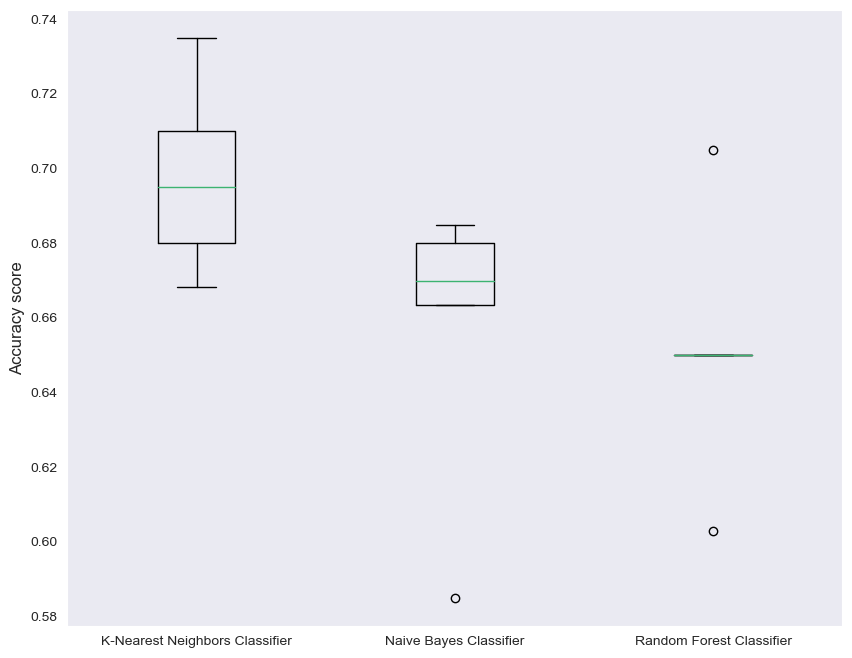

K-Nearest Neighbors Classifier Test Set Accuracy: 0.676
Naive Bayes Classifier Test Set Accuracy: 0.624
Random Forest Classifier Test Set Accuracy: 0.592


In [82]:
# Evaluating multiple models
def boxplot_cv_performances_from_pipes() -> None:
    results = []

    for pipeline in pipelines.values():
        kf = KFold(n_splits=5)
        cv_results = cross_val_score(pipeline, x_train, y_train, cv=kf)
        results.append(cv_results)

    # Plot Cross-Validation Performance
    sns.set_style('dark')
    plt.figure(figsize=(10, 8))
    plt.boxplot(results, labels=pipelines.keys(), medianprops={'color': 'mediumseagreen'})
    plt.ylabel('Accuracy score', fontsize=12)

    plt.show()

    # Test set performance
    for name, pipeline in pipelines.items():
        pipeline.fit(x_train, y_train)
        test_score = pipeline.score(x_test, y_test)
        print(f"{name} Test Set Accuracy: {test_score}")


print('Figure 3. Cross-Validation Performance of the three models')
boxplot_cv_performances_from_pipes()

As mentioned above, we can use different metrics to evaluate the performance of our model.

Figure 4 represents the distribution of accuracy scores (percentage of correct predictions) obtained by cross-validation, which divides the data set into several folders, using one folder as the validation set and the others as the training set. This process is repeated for each folder and finally, the results are combined, such as by calculating the mean, to obtain an estimate of the model performance. We can visually see what was expressed in table 3 confirming that Naive Bayes Classification has the best performance.

Another way is to use the ROC-AUC and PR-AUC curves to measure the ability of a classification model to discriminate between two classes, but they focus on different aspects.

The ROC curve represents the model's ability to discriminate between positive and negative classes. The ROC curve shows the relationship between the True Positive Rate (TPR), which is the percentage of true positives classified correctly to total positives, on the y-axis and the False Positive Rate (FPR), which is the percentage of false positives classified incorrectly to total negatives, on the x-axis. To create the curve, the model's classification threshold, which determines the cut-off point between positive and negative classes, is varied. At each threshold value, the corresponding TPR and FPR value is calculated and a point is drawn on the ROC curve. An ideal ROC curve should get as close as possible to the upper left side of the graph, indicating a high TPR and low FPR. The closer the ROC AUC value is to 1, the better the model's ability to distinguish between the two classes.

On the other hand, the PR curve represents the trade-off between Precision and Recall, highlighting the model's ability to find all positives (Recall) and classify them correctly (Precision), but does not account for negatives. The PR curve is obtained by plotting Precision on the y-axis and Recall on the x-axis. To construct the curve, one starts with the highest recall value 1 and calculates the corresponding precision. Then, you move to the right along the x-axis (i.e., decrease the recall value) and calculate the corresponding precision. You repeat the process until you arrive at the lowest recall value 0. An ideal PR curve should come as close as possible to the upper right side of the graph, indicating high Precision and high Recall.

Figure 5 below demonstrates that although all models performed better than the base rate, the worst-performing model concerning the ROC-AUC and PR-AUC metrics is K-Nearest Neighbors Classifier. Therefore, we decided to perform Hyperparameter tuning Naive Bayes Classification to see if we are able to obtain better performance.

Figure 4. Test set area under the ROC curve and PR curve


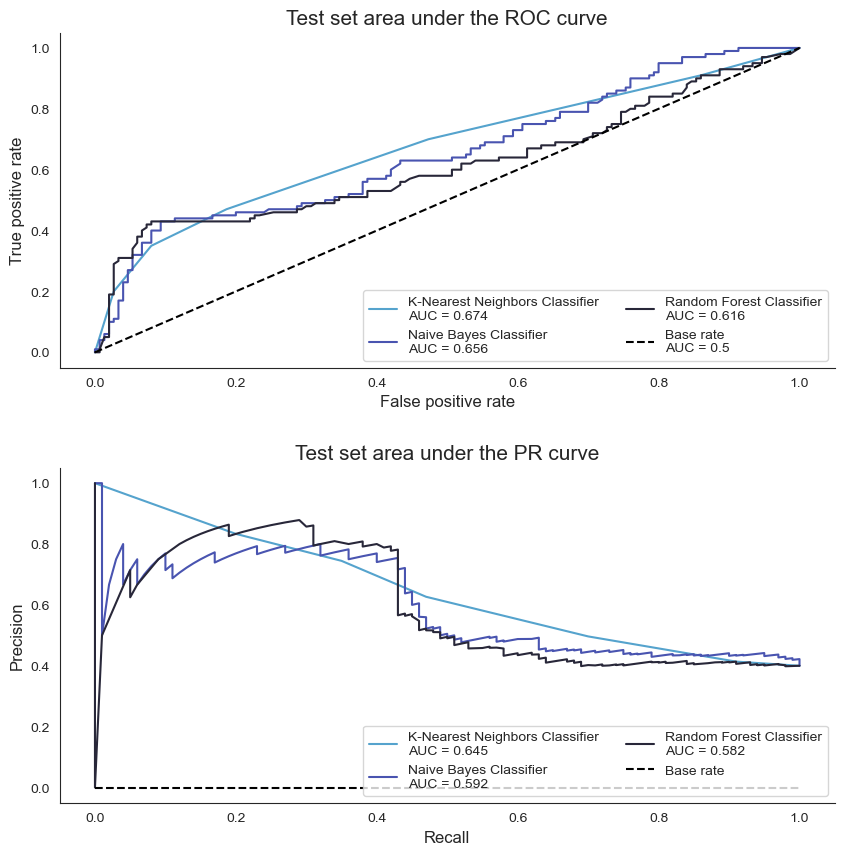

In [83]:
def roc_pr_auc_curves_from_pipes() -> None:
    fprss = []
    tprss = []
    precs = []
    recs = []
    roc_aucs = []
    pr_aucs = []

    for name, pipeline in pipelines.items():
        y_probs = pipeline.predict_proba(x_test)[:, 1]

        fprs, tprs, _ = roc_curve(y_test, y_probs)
        precisions, recalls, _ = precision_recall_curve(y_test, y_probs)

        fprss.append(fprs)
        tprss.append(tprs)
        precs.append(precisions)
        recs.append(recalls)
        roc_aucs.append(roc_auc_score(y_test, y_probs))
        pr_aucs.append(auc(recalls, precisions))

    sns.set_style('white')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    for i in range(len(fprss)):
        model_name = list(pipelines.keys())[i]
        label_model = f"{model_name}\nAUC = {roc_aucs[i]:.3f}"
        ax1.plot(fprss[i], tprss[i], label=label_model)
    ax1.plot([0, 1], [0, 1], linestyle='--', label='Base rate\nAUC = 0.5', color='black')
    ax1.set_xlabel('False positive rate', fontsize=12)
    ax1.set_ylabel('True positive rate', fontsize=12)
    ax1.set_title('Test set area under the ROC curve', fontsize=15)
    ax1.legend(loc="lower right", ncol=2, frameon=True)

    for i in range(len(precs)):
        model_name = list(pipelines.keys())[i]
        label_model = f"{model_name}\nAUC = {pr_aucs[i]:.3f}"
        ax2.plot(recs[i], precs[i], label=label_model)
    ax2.plot([0, 1], [0, 0], linestyle='--', label='Base rate', color='black')
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title('Test set area under the PR curve', fontsize=15)
    ax2.legend(loc="lower right", ncol=2, frameon=True)
    plt.subplots_adjust(hspace=0.3)
    sns.despine()

    plt.show()


print('Figure 4. Test set area under the ROC curve and PR curve')
roc_pr_auc_curves_from_pipes()

In [84]:
# Hyperparameter tuning Naive Bayes Classifier
def hyperparameter_tuning_naive_bayes_classifier() -> Tuple[BayesSearchCV, float]:
    np.int = np.int64
    start_time = time.time()
    param_grid = {'gaussiannb__var_smoothing': (1e-10, 1e-9, 'log-uniform')}

    cv = StratifiedKFold(shuffle=True, random_state=seed)

    grid_lr_ = BayesSearchCV(estimator=pipelines['Naive Bayes Classifier'],
                             search_spaces=param_grid,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=-1)

    grid_lr_.fit(x_train, y_train)

    end_time = time.time()
    execution_time_ = (end_time - start_time) / 60

    return grid_lr_, execution_time_


grid_lr, execution_time = hyperparameter_tuning_naive_bayes_classifier()
print(f'The best estimator is: {grid_lr.best_estimator_}\n'
      f'The best params are: {grid_lr.best_params_}\n'
      f'The best score is: {grid_lr.best_score_}\n'
      f'Execution time: {execution_time:.3f} minutes')

The best estimator is: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['Age', 'AnnualIncome',
                                                   'FamilyMembers']),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  ['Employment Type',
                                                   'GraduateOrNot',
                                                   'ChronicDiseases',
                                                   'FrequentFlyer',
                                                   'EverTravelledAbroad'])])),
                ('gaussiannb',
                 GaussianNB(var_smoothing=2.0125934269698208e-10))])
The best params are: OrderedDict([('gaussiannb__var_smoothing', 2.0125

The final algorithm, optimized through the use of BayesSearchCV, was evaluated on the test data (Table 4, Figure 5) and shown to have:
- an accuracy of 62.4%,
- an area under the precision-recall curve (PR_AUC) of 59.2% ,
- an area under the receiver operating characteristic curve (ROC_AUC) of 65.5%.

These results indicate that **the algorithm can distinguish between customers buy and don't buy travel insurance with a probability between 59.2% and 65.5%,** depending on the chosen metric.

In addition, the algorithm **correctly classified 47 customers buy travel insurance (true positives) and 109 customers don't buy travel insurance (true negatives)** out of a total of 250 customers in the test set. However, the algorithm also made errors, with **53 customers buy travel insurance misclassified as don't buy insurance (type I errors) and 41 customers don't buy travel insurance misclassified as buy insurance (type II errors),** as highlighted in Figure 6.

In [85]:
# Getting metrics from tuned model
def metrics_test_from_tuned(model: BayesSearchCV) -> pd.io.formats.style.Styler:
    test_accs = []
    test_f1s = []
    test_roc_aucs = []
    test_pr_aucs = []
    test_precs = []
    test_recs = []
    test_specs = []
    test_fprs_list = []
    test_fnrs_list = []

    mod = model.best_estimator_
    y_pred_test = mod.predict(x_test)

    y_probs_test = mod.predict_proba(x_test)[:, 1]

    test_precisions, test_recalls, threshold = precision_recall_curve(y_test, y_probs_test)

    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()

    test_accs.append(accuracy_score(y_test, y_pred_test))
    test_f1s.append(f1_score(y_test, y_pred_test))
    test_roc_aucs.append(roc_auc_score(y_test, y_probs_test))
    test_pr_aucs.append(auc(test_recalls, test_precisions))
    test_precs.append(precision_score(y_test, y_pred_test))
    test_recs.append(recall_score(y_test, y_pred_test))
    test_specs.append(tn_test / (tn_test + fp_test))
    test_fprs_list.append(fp_test / (fp_test + tn_test))
    test_fnrs_list.append(fn_test / (fn_test + tp_test))

    test_metrics = pd.DataFrame(
        {'model': [model.best_estimator_.steps[-1][1].__class__.__name__],
         'accuracy': test_accs,
         'f1_score': test_f1s,
         'roc_auc': test_roc_aucs,
         'pr_auc': test_pr_aucs,
         'precision': test_precs,
         'recall': test_recs,
         'specificity': test_specs,
         'false_positive_rate': test_fprs_list,
         'false_negative_rate': test_fnrs_list})

    return test_metrics.transpose().reset_index().rename(columns={'index': 'metrics', 0: 'values'}).style \
        .set_properties(**{'font-size': '10pt',
                           'text-align': 'center'}) \
        .set_caption('Table 4: Best estimator metrics table.')


metrics_test_from_tuned(grid_lr)

,metrics,values
0,model,GaussianNB
1,accuracy,0.624000
2,f1_score,0.500000
3,roc_auc,0.655800
4,pr_auc,0.592334
5,precision,0.534091
6,recall,0.470000
7,specificity,0.726667
8,false_positive_rate,0.273333
9,false_negative_rate,0.530000


Figure 5: Best model ROC and PR curves


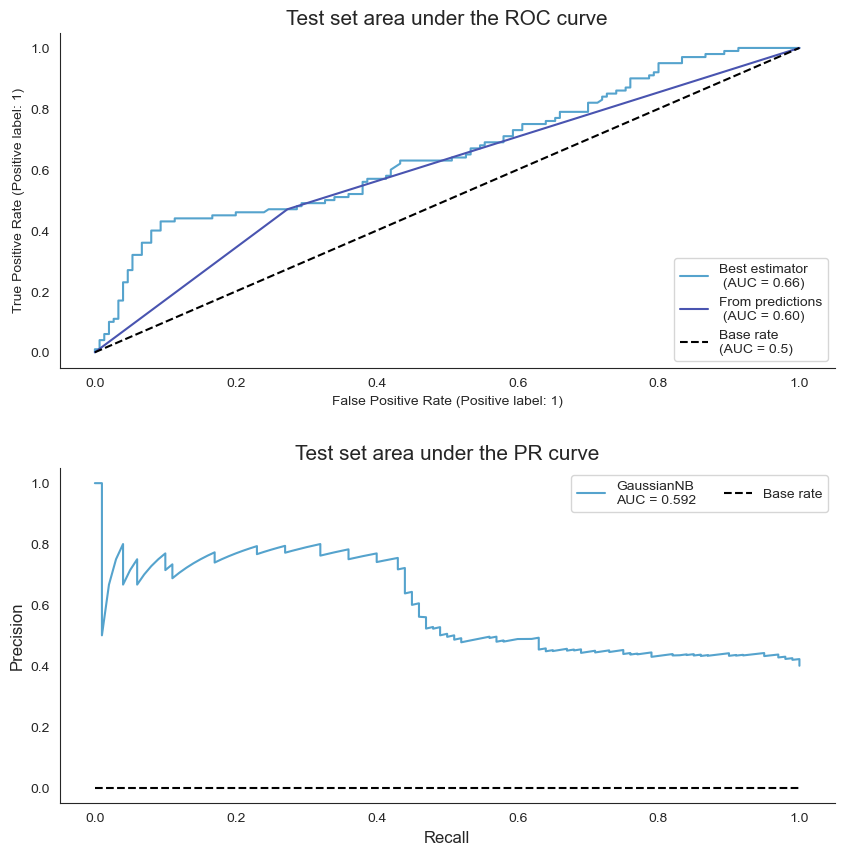

In [86]:
# Plot roc_pr_auc curves from best estimator
def roc_pr_auc_curves_from_best_estimator(model):
    precs = []
    recs = []
    pr_aucs = []

    mod = model.best_estimator_
    y_pred = model.predict(x_test)
    y_probs = mod.predict_proba(x_test)[:, 1]

    precisions, recalls, _ = precision_recall_curve(y_test, y_probs)
    precs.append(precisions)
    recs.append(recalls)
    pr_aucs.append(auc(recalls, precisions))

    sns.set_style('white')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    RocCurveDisplay.from_estimator(mod, x_test, y_test, name='Best estimator\n', ax=ax1)
    RocCurveDisplay.from_predictions(y_test, y_pred, name='From predictions\n', ax=ax1)
    ax1.plot([0, 1], ls="--", color='k', label='Base rate\n(AUC = 0.5)')
    ax1.set_title('Test set area under the ROC curve', fontsize=15)
    ax1.legend(loc='lower right', bbox_to_anchor=(1, 0))
    sns.despine()

    for i in range(len(precs)):
        model_name = model.best_estimator_.steps[-1][1].__class__.__name__
        label_model = f"{model_name}\nAUC = {pr_aucs[i]:.3f}"
        ax2.plot(recs[i], precs[i], label=label_model)
    ax2.plot([0, 1], [0, 0], linestyle='--', label='Base rate', color='black')
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title('Test set area under the PR curve', fontsize=15)
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 1), ncol=2, frameon=True)
    plt.subplots_adjust(hspace=0.3)
    sns.despine()


print('Figure 5: Best model ROC and PR curves')
roc_pr_auc_curves_from_best_estimator(grid_lr)

**Note:** The difference between the two AUC (Area Under the Curve) might indicate that the better model performs slightly better on the test set than its predictions alone (y_pred). However, the 4% difference between the two AUCs is not very large and may not be statistically significant.

Figure 6: Best estimator confusion matrix.


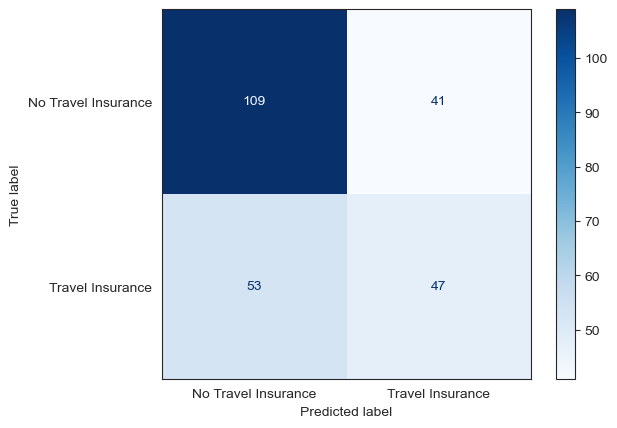

In [87]:
# Plot confusion matrix from best estimator
def plot_confusion_matrix_from_best_estimator(model):
    y_pred = model.predict(x_test)

    cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),
                                display_labels=['No Travel Insurance', 'Travel Insurance'])

    print('Figure 6: Best estimator confusion matrix.')
    cm.plot(cmap='Blues')
    plt.show()


plot_confusion_matrix_from_best_estimator(grid_lr)